


todo: 
* figure out why the evals are returning NaN
* write perceptual checks
* normalize robustness/make it better at the expense of perception
* separate the time and transform watermark outside the combo file
* clean code (type returns etc)


notes:
had to clone and build aquatk - pip install doesnt work yet, missing folders, so had to edit __init__ to get it working. also had to edit a lot of things. including imports and relativity. also it takes filenames, not data, so scrapped it. 

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import soundfile as sf
import numpy as np
from IPython.display import Audio 
import pandas as pd
import librosa
import time
from aquatk.metrics import PEAQ
import json
import seaborn as sns # add to requirements
import matplotlib.pyplot as plt # add to requirements

from globals import hop_length, qim_parameters, domain_choice, n_fft, smoothing_window, attack_names, metric_names_r, metric_names_p, watermark_names, evaluation_type
from combo import Echo, Embeds, precalculate_frame_domains, WatermarkDCT
from utils.evaluation.evaluation import RobustnessEvaluation
from utils.watermark.util import tobits, frombits, visual_bitwise_check, even_audio
from utils.watermark.window import Window
from utils.evaluation.perceptual_evaluation import PerceptualEvaluation


### TESTS

In [3]:
# test aquatk fork edits 
ref_filename = "data/hw2_audio.wav"
test_filename = "hw2_watermarked.wav"
aquatk_test_flag = tobits("flag{yeah_but_also_no}")
aquatk_test_w_hybrid = Embeds(aquatk_test_flag)
aquatk_test_audio, aquatk_test_sr = librosa.load(ref_filename, sr=None)
aquatk_test_embed_designations = precalculate_frame_domains(aquatk_test_audio, aquatk_test_sr)
aquatk_test_wm_hybrid = aquatk_test_w_hybrid.embed_combo_watermark(aquatk_test_embed_designations, aquatk_test_audio, aquatk_test_sr)

# comparison
info = sf.info(ref_filename)
sf.write(test_filename, aquatk_test_wm_hybrid, aquatk_test_sr, subtype=info.subtype)
info2 = sf.info(test_filename)

assert info.channels == info2.channels
assert info.format == info2.format 
assert info.samplerate == info2.samplerate
assert info.subtype == info2.subtype

# compare file vs data
aquatk_test_audio, aquatk_test_sr = librosa.load(ref_filename, sr=None)
aquatk_test_audio2, aquatk_test_sr2 = librosa.load(test_filename, sr=None)

aquatk_test_perceptual_data = PEAQ.peaq_basic.process_audio_data(ref_audio=aquatk_test_audio, ref_rate=aquatk_test_sr, test_audio=aquatk_test_audio2, test_rate=aquatk_test_sr2)
aquatk_test_perceptual_file = PEAQ.peaq_basic.process_audio_files(ref_filename=ref_filename, test_filename=test_filename)

# same dict
assert len(aquatk_test_perceptual_data) == len(aquatk_test_perceptual_file)
assert aquatk_test_perceptual_file[metric_names_p[0]] == aquatk_test_perceptual_data[metric_names_p[0]]
assert aquatk_test_perceptual_file[metric_names_p[1]] == aquatk_test_perceptual_data[metric_names_p[1]]

Created 299 blocks
int16
32356 -30844
Created 299 blocks
int16
32515 -32599


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/neural.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


KeyboardInterrupt: 

In [ ]:
# runtime check Window
audio_windowtest,sr_windowtest = sf.read("data/hw2_audio.wav")
audio_windowtest = even_audio(audio_windowtest)

window_windowtest = Window(1024, np.hanning)
window_windowtest.apply_window(len(audio_windowtest) // 2, audio_windowtest)

array([-0.00000000e+00, -3.43284727e-13, -3.81427474e-12, ...,
        3.99227423e-11,  1.00220069e-11,  0.00000000e+00])

In [ ]:
# runtime check MDCT
# audio_mdcttest,sr_mdcttest = sf.read("data/hw2_audio.wav")
# len_audio_mdcttest = len(audio_mdcttest)
# window_mdcttest = Window(1024, np.hanning) # TODO sine window

# print("making DCT object")
# starttime_mdcttest = perf_counter()
# mdct_mdcttest = dct_transform.DCT(window_mdcttest)
# endtime_mdcttest = perf_counter()
# print(f"DCT object timing: {endtime_mdcttest - starttime_mdcttest}\n")

# print("dct")
# starttime_mdcttest = perf_counter()
# res_mdcttest = mdct_mdcttest.windowed_dct(audio_mdcttest)
# endtime_mdcttest = perf_counter()
# print(f"DCT timing: {endtime_mdcttest - starttime_mdcttest}\n")

# print("idct")
# starttime_mdcttest = perf_counter()
# rev_mdcttest = mdct_mdcttest.windowed_idct(res_mdcttest, audio_mdcttest)
# endtime_mdcttest = perf_counter()
# print(f"IDCT timing: {endtime_mdcttest - starttime_mdcttest}\n")

# assert len(audio_mdcttest) == len(rev_mdcttest)

# # original
# Audio(audio_mdcttest, rate=sr_mdcttest)

# # dct and idct transformation
# Audio(rev_mdcttest, rate=sr_mdcttest)

In [ ]:
# runtime check watermarkDct
audio_wmtest,sr_wmtest = sf.read("data/hw2_audio.wav")

wm = "flag{this is a watermark test string let's see how it does!}"
wmbits = ''.join(format(ord(i), '08b') for i in wm)
watermark_test = transform_watermark.WatermarkDCT(np.hanning, wmbits) # random string len 45

output = watermark_test.apply_watermark(audio_wmtest)
extracted_watermark = watermark_test.extract_watermark(output, len(wmbits))

# watermark extraction check
exwmbits = "".join([str(int(x)) for x in extracted_watermark])
assert len(exwmbits) == len(wmbits)
print(exwmbits)
print(wmbits)
print(watermark_utils.visual_bitwise_check(wmbits, exwmbits)) # bitwise equals

# evaluation
robev = evaluation.RobustnessEvaluation()
print(robev.eval_all(wmbits, extracted_watermark))

# watermarked audio
Audio(output, rate=sr_wmtest)

In [ ]:
# runtime check echo



In [ ]:
# runtime check hybrid


In [ ]:
# eval check

## Evaluation

In [4]:
# for all watermarks
flag = tobits("flag{yeah_but_also_no}")
r = RobustnessEvaluation()
r_attacks = [r.resample, r.requantize, r.noise, r.lowpass, r.highpass, r.amplitude]
p = PerceptualEvaluation()

In [40]:
class Results:
    attacks = attack_names
    evaluations_r = metric_names_r
    evaluations_p = metric_names_p
    watermarks = watermark_names
    column_names_r = ["audio_id", "watermark_type", "attack", "metric", "value"]
    column_names_p = ["audio_id", "watermark_type", "metric", "value"]
    results_robust = []
    results_perceptual = []

    def add_set_robust(self, audio_id, attack, wm, res):
        if attack not in self.attacks:
            print(f"attack {attack} not supported, please pick from {self.attacks}")

        for ev in res:
            if ev not in self.evaluations_r:
                print(f"eval metric {ev} not supported, please pick from {self.evaluations_r}")
                return -1
            re = res[ev]
            self.results_robust.append({
                self.column_names_r[0]: audio_id,
                self.column_names_r[1]: wm,
                self.column_names_r[2]: attack,
                self.column_names_r[3]: ev, 
                self.column_names_r[4]: re
            })

    def add_set_perceptual(self, audio_id, wm, res):
        for ev in res:
            if ev not in self.evaluations_p:
                print(f"eval metric {ev} not supported, please pick from {self.evaluations_p}")
                return -1
            re = res[ev]
            self.results_perceptual.append({
                self.column_names_p[0]: audio_id, 
                self.column_names_p[1]: wm,
                self.column_names_p[2]: ev, 
                self.column_names_p[3]: re
            })

    def load_saved_data(self, robust_file, perceptual_file):
        with open(robust_file, "r") as f:
            f_js = f.read()
            self.results_robust = json.loads(f_js)

        with open(perceptual_file, "r") as f:
            f_js = f.read()
            self.results_perceptual = json.loads(f_js)

    def convert_robust(self):
        self.df_robust = pd.DataFrame(self.results_robust)

    def convert_perceptual(self):
        self.df_perceptual = pd.DataFrame(self.results_perceptual)


class FullEval:
    def __init__(self, he_flag):
        # only state: flag, watermark class objects, results class
        self.flag = he_flag
        self.w_hybrid = Embeds(he_flag) # todo for all three - take sample rate here
        self.w_transform = WatermarkDCT(window_func=qim_parameters.WINDOW_FUNC, watermark=flag)
        self.w_time = Echo() # take watermark here instead of embed func
        self.results = Results()

    def _run_all_embed(self, he_designations, he_audio, he_sr):
        # hybrid embed
        wm_hybrid = self.w_hybrid.embed_combo_watermark(he_designations, he_audio, he_sr)
        wm_transform = self.w_transform.embed_qim_full(he_audio, alpha=qim_parameters.ALPHA)
        wm_time = self.w_time.full_embed_watermark(he_audio, he_sr, self.flag)

        return wm_hybrid, wm_transform, wm_time

    def _run_all_extract(self, he_designations, wm_hybrid, wm_transform, wm_time, he_sr):
        wmbits_hybrid = self.w_hybrid.extract_combo_watermark(designations=he_designations, audio=wm_hybrid, sr=he_sr)
        extracted_hybrid = bin(wmbits_hybrid)[2:].zfill(len(he_designations) - 2)

        wmbits_transform = self.w_transform.extract_watermark(wm_transform)
        extracted_transform = "".join(wmbits_transform)

        wmbits_time = self.w_time.full_extract_watermark(wm_time, he_sr)
        extracted_time = "".join(wmbits_time)

        return extracted_hybrid, extracted_transform, extracted_time
    
    def _run_all_attacks(self):
        pass
    
    def _run_all_eval_r(self, audio_id, attack, he_actual, extracted_hybrid, extracted_transform, extracted_time):
        visual_hybrid = visual_bitwise_check(he_actual, extracted_hybrid[:len(he_actual)])
        numbers_hybrid = r.eval_all(real=he_actual, extracted=extracted_hybrid[:len(he_actual)])

        visual_transform = visual_bitwise_check(he_actual, extracted_transform[:len(he_actual)])
        numbers_transform = r.eval_all(real=he_actual, extracted=extracted_transform[:len(he_actual)])

        visual_time = visual_bitwise_check(he_actual, extracted_time[:len(he_actual)])
        numbers_time = r.eval_all(real=he_actual, extracted=extracted_time[:len(he_actual)])

        self.results.add_set_robust(audio_id, attack, watermark_names[0], numbers_hybrid)
        self.results.add_set_robust(audio_id, attack, watermark_names[1], numbers_transform)
        self.results.add_set_robust(audio_id, attack, watermark_names[2], numbers_time)

        return numbers_hybrid, numbers_transform, numbers_time
    
    def _run_all_eval_p(self, audio_id, original_audio, wm_hybrid, wm_transform, wm_time, sr):
        res_hybrid = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_hybrid, sr=sr)
        res_transform = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_transform, sr=sr)
        res_time = p.evaluate_watermark(original_audio=original_audio, watermarked_audio=wm_time, sr=sr)

        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[0], res=res_hybrid)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[1], res=res_transform)
        self.results.add_set_perceptual(audio_id=audio_id, wm=watermark_names[2], res=res_time)
        
        
    def run_all(self, audio_id, he_audio, he_sr):
        starttime = time.perf_counter() #
        frames = len(he_audio) // hop_length
        repeats = frames // len(self.flag)
        actual = "".join(str(bit) for bit in self.flag)*repeats
        endtime = time.perf_counter() #
        print(f"here at PRECALC {endtime - starttime}") #

        starttime = time.perf_counter() #
        # embed all
        embed_designations = precalculate_frame_domains(he_audio, he_sr)
        wm_hybrid, wm_transform, wm_time = self._run_all_embed(he_designations=embed_designations, he_audio=he_audio, he_sr=he_sr)
        endtime = time.perf_counter() #
        print(f"here at EMBED {endtime - starttime}") #

        starttime = time.perf_counter() #
        # perceptual eval
        self._run_all_eval_p(audio_id, he_audio, wm_hybrid, wm_transform, wm_time, sr=he_sr)
        endtime = time.perf_counter() #
        print(f"here at PERCEPTION EVAL {endtime - starttime}") #

        

        # run attacks, all separately, then all together
        for at in range(len(attack_names)):
            attack = attack_names[at]

            if at != 0:
                wm_hybrid_processed = r_attacks[at - 1](audio=wm_hybrid, sr=he_sr)
                wm_transform_processed = r_attacks[at - 1](audio=wm_transform, sr=he_sr)
                wm_time_processed = r_attacks[at - 1](audio=wm_time, sr=he_sr)
            else:
                wm_hybrid_processed = wm_hybrid
                wm_transform_processed = wm_transform
                wm_time_processed = wm_time

            starttime = time.perf_counter() #
            # extract all
            extract_designations = precalculate_frame_domains(wm_hybrid_processed, he_sr)
            extracted_hybrid, extracted_transform, extracted_time = self._run_all_extract(extract_designations, wm_hybrid_processed, wm_transform_processed, wm_time_processed, he_sr)
            endtime = time.perf_counter() #
            print(f"here at EXTRACT {endtime - starttime}") #

            starttime = time.perf_counter() #
            # evaluate robustness
            self._run_all_eval_r(audio_id, attack, actual, extracted_hybrid, extracted_transform, extracted_time)
            endtime = time.perf_counter() #
            print(f"here at ROBUSTNESS EVAL {endtime - starttime}") #
        
        

In [41]:
# if saved data, add from saved_data_{type}.json

fe = FullEval(flag)
robust_file = "saved_data_robust.json"
perceptual_file = "saved_data_perceptual.json"
fe.results.load_saved_data(robust_file=robust_file, perceptual_file=perceptual_file)

def create_data(start_cd, stop_cd):
    broke = 0
    for i in range(start_cd, stop_cd):
        print(i)
        try:
            start_time = time.perf_counter()
            id = str(i).zfill(3)
            audio, sr = librosa.load(f"data/000/000{id}.mp3", sr=None)
            fe.run_all(audio_id=id, he_audio=audio, he_sr=sr)
            end_time = time.perf_counter()
            print(i)
            print(end_time - start_time)
            print("")
        except Exception as e:
            print(e)
            broke += 1
    print(broke)

start = 50
stop = 150
create_data(start, stop)

50
[Errno 2] No such file or directory: 'data/000/000050.mp3'
51
[Errno 2] No such file or directory: 'data/000/000051.mp3'
52
[Errno 2] No such file or directory: 'data/000/000052.mp3'
53
[Errno 2] No such file or directory: 'data/000/000053.mp3'
54
[Errno 2] No such file or directory: 'data/000/000054.mp3'
55
[Errno 2] No such file or directory: 'data/000/000055.mp3'
56
[Errno 2] No such file or directory: 'data/000/000056.mp3'
57
[Errno 2] No such file or directory: 'data/000/000057.mp3'
58
[Errno 2] No such file or directory: 'data/000/000058.mp3'
59
[Errno 2] No such file or directory: 'data/000/000059.mp3'
60
[Errno 2] No such file or directory: 'data/000/000060.mp3'
61
[Errno 2] No such file or directory: 'data/000/000061.mp3'
62
[Errno 2] No such file or directory: 'data/000/000062.mp3'
63
[Errno 2] No such file or directory: 'data/000/000063.mp3'
64
[Errno 2] No such file or directory: 'data/000/000064.mp3'
65
[Errno 2] No such file or directory: 'data/000/000065.mp3'
66
[Errn

/tmp/ipykernel_2118207/2526075291.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(f"data/000/000{id}.mp3", sr=None)
/home/ara/.local/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


here at EMBED 14.300605299009476
Created 1291 blocks
int16
17287 -17287
Created 1291 blocks
int16
17677 -17677


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/neural.py:33: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Created 1291 blocks
int16
17287 -17287
Created 1291 blocks
int16
17524 -17266
Created 1291 blocks
int16
17288 -17288
Created 1291 blocks
int16
17288 -17288


/home/ara/.local/lib/python3.13/site-packages/aquatk/metrics/PEAQ/MOV.py:136: RuntimeWarning: invalid value encountered in scalar divide
  C[i] = num / (sqrt(denoma) * sqrt(denomb))


here at PERCEPTION EVAL 1301.6706445119926
here at EXTRACT 7.747016507026274
here at ROBUSTNESS EVAL 0.0009468480129726231
here at EXTRACT 9.10419958800776
here at ROBUSTNESS EVAL 0.0010932880104519427
here at EXTRACT 7.752573003992438
here at ROBUSTNESS EVAL 0.0009517159778624773
here at EXTRACT 7.683760826999787
here at ROBUSTNESS EVAL 0.0009289459558203816
here at EXTRACT 8.094047744991258
here at ROBUSTNESS EVAL 0.0010063470108434558


/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/lib64/python3.13/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


here at EXTRACT 3.3811903320020065
here at ROBUSTNESS EVAL 0.0009004569728858769
here at EXTRACT 7.844868263986427
here at ROBUSTNESS EVAL 0.0009290400194004178
134
1367.7797606950044

135
here at PRECALC 2.8982991352677345e-05
here at EMBED 22.5553791730199
Created 1289 blocks
int16
7675 -8466
Created 1289 blocks
int16
7531 -8516
Created 1289 blocks
int16
7675 -8466
Created 1289 blocks
int16
7389 -8046
Created 1289 blocks
int16
7675 -8467
Created 1289 blocks
int16
7675 -8467
here at PERCEPTION EVAL 1151.060350158019
here at EXTRACT 11.87791689299047
here at ROBUSTNESS EVAL 0.000791915983427316
here at EXTRACT 11.646348645037506
here at ROBUSTNESS EVAL 0.0010157210053876042
here at EXTRACT 11.673777438001707
here at ROBUSTNESS EVAL 0.0009715919732116163
here at EXTRACT 10.807088773988653
here at ROBUSTNESS EVAL 0.0009270589798688889
here at EXTRACT 12.073063293995801
here at ROBUSTNESS EVAL 0.0009665919933468103
here at EXTRACT 8.804712392971851
here at ROBUSTNESS EVAL 0.00092481804313

In [7]:
fe.results.results_perceptual

[{'audio_id': '002',
  'watermark_type': 'Time Domain Watermark',
  'metric': 'Distortion Index',
  'value': 7.9801498407861065},
 {'audio_id': '002',
  'watermark_type': 'Time Domain Watermark',
  'metric': 'Objective Difference Grade',
  'value': 0.21856318709494105}]

In [42]:
import json

file_path = "saved_data_robust.json"
with open(file_path, "w") as f:
    json.dump(fe.results.results_robust, f, indent=4)

file_path = "saved_data_perceptual.json"
with open(file_path, "w") as f:
    json.dump(fe.results.results_perceptual, f, indent=4)

# with open("saved_data_perceptual.json", "r") as f:
#     f_js = f.read()
#     fe.results.results_perceptual = json.loads(f_js)


In [50]:
fe.results.convert_robust()
df_robust = fe.results.df_robust
print(df_robust)

    audio_id              watermark_type     attack                  metric  \
0        002     Hybrid Domain Watermark       None          Detection Rate   
1        002     Hybrid Domain Watermark       None               Precision   
2        002     Hybrid Domain Watermark       None  Normalized Correlation   
3        002     Hybrid Domain Watermark       None          Bit Error Rate   
4        002  Transform Domain Watermark       None          Detection Rate   
..       ...                         ...        ...                     ...   
751      048  Transform Domain Watermark  Amplitude          Bit Error Rate   
752      048       Time Domain Watermark  Amplitude          Detection Rate   
753      048       Time Domain Watermark  Amplitude               Precision   
754      048       Time Domain Watermark  Amplitude  Normalized Correlation   
755      048       Time Domain Watermark  Amplitude          Bit Error Rate   

        value  
0    0.803922  
1    0.982877  
2  

In [12]:
fe.results.convert_perceptual()
df_perceptual = fe.results.df_perceptual
print(df_perceptual)

   audio_id              watermark_type                      metric     value
0       002     Hybrid Domain Watermark            Distortion Index  2.100948
1       002     Hybrid Domain Watermark  Objective Difference Grade -0.717300
2       002  Transform Domain Watermark            Distortion Index  0.195849
3       002  Transform Domain Watermark  Objective Difference Grade -1.839449
4       002       Time Domain Watermark            Distortion Index  7.990489
5       002       Time Domain Watermark  Objective Difference Grade  0.218578
6       003     Hybrid Domain Watermark            Distortion Index  1.996528
7       003     Hybrid Domain Watermark  Objective Difference Grade -0.749376
8       003  Transform Domain Watermark            Distortion Index  0.128976
9       003  Transform Domain Watermark  Objective Difference Grade -1.896423
10      003       Time Domain Watermark            Distortion Index  8.018005
11      003       Time Domain Watermark  Objective Difference Gr

In [52]:
df = df_robust

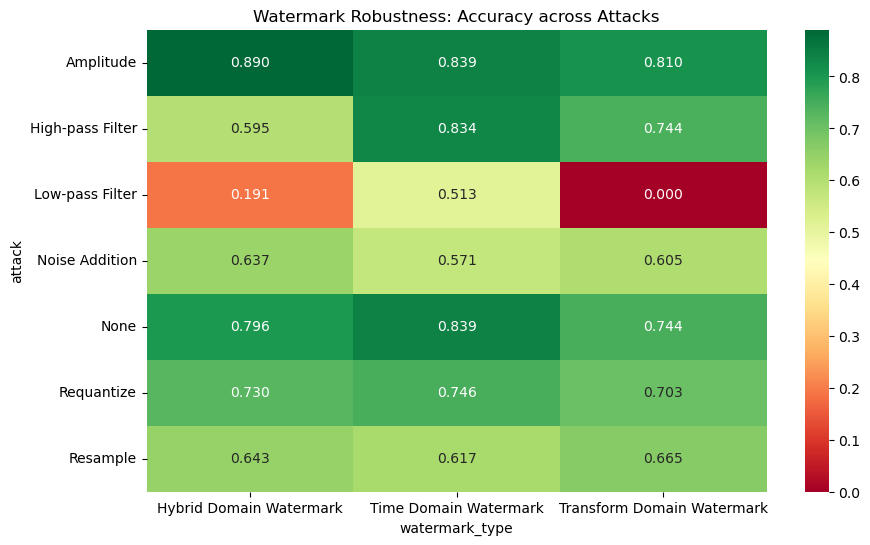

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot to show watermark performance across attacks for one metric
pivot = df[df['metric'] == metric_names_r[0]].pivot_table(
    values='value', 
    index='attack', 
    columns='watermark_type', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn')
plt.title('Watermark Robustness: Accuracy across Attacks')
plt.show()

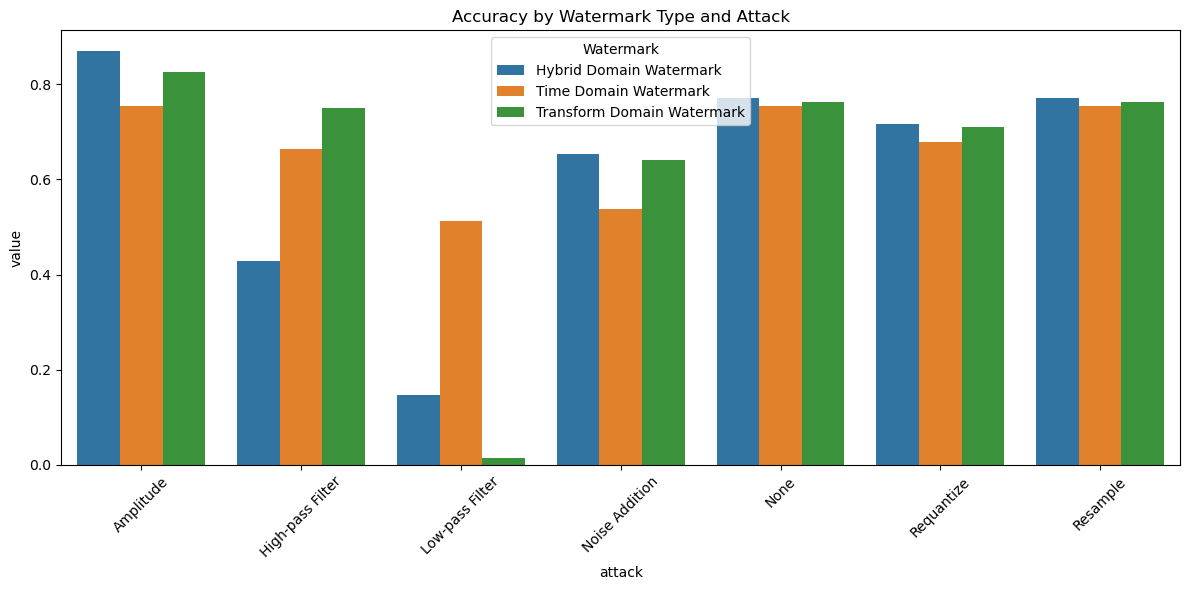

In [ ]:
# Average across all audios
summary = df.groupby(['watermark_type', 'attack', 'metric'])['value'].mean().reset_index()

# Plot one metric
metric_data = summary[summary['metric'] == metric_names_r[0]]

plt.figure(figsize=(12, 6))
sns.barplot(data=metric_data, x='attack', y='value', hue='watermark_type')
plt.title('Accuracy by Watermark Type and Attack')
plt.xticks(rotation=45)
plt.legend(title='Watermark')
plt.tight_layout()
plt.show()

/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ara/.local/lib/python3.13/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

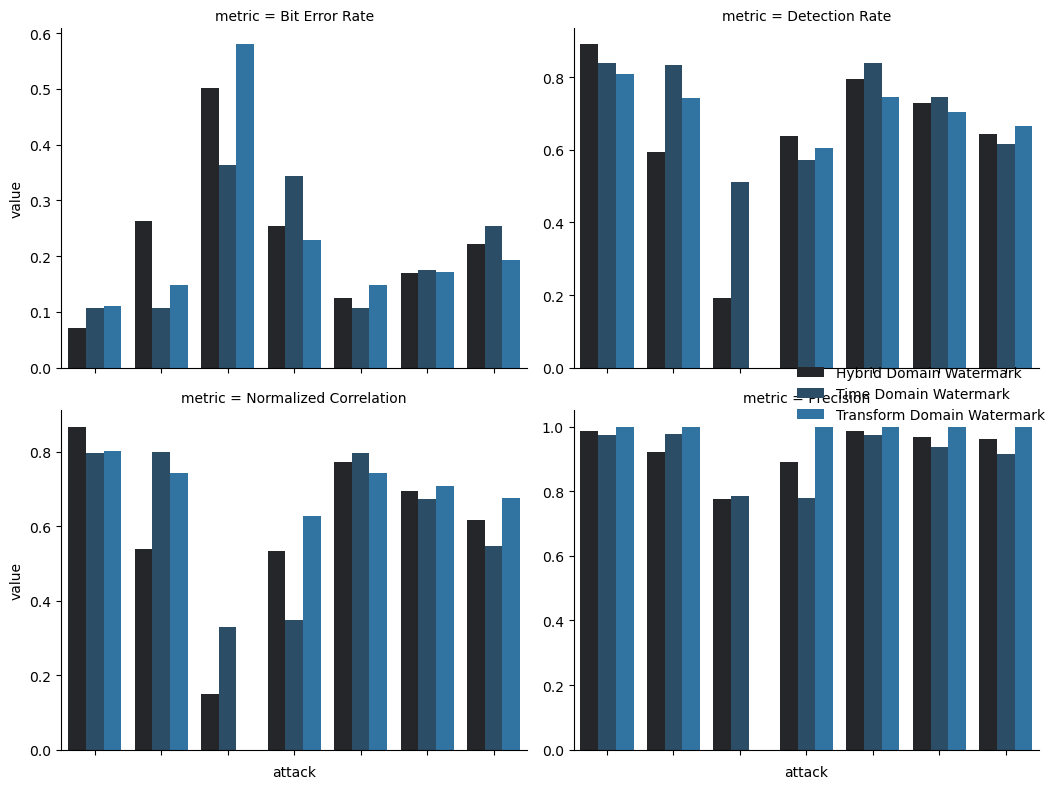

In [55]:
summary = df.groupby(['watermark_type', 'attack', 'metric'])['value'].mean().reset_index()

g = sns.FacetGrid(summary, col='metric', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.barplot, x='attack', y='value', hue='watermark_type')
g.add_legend()
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

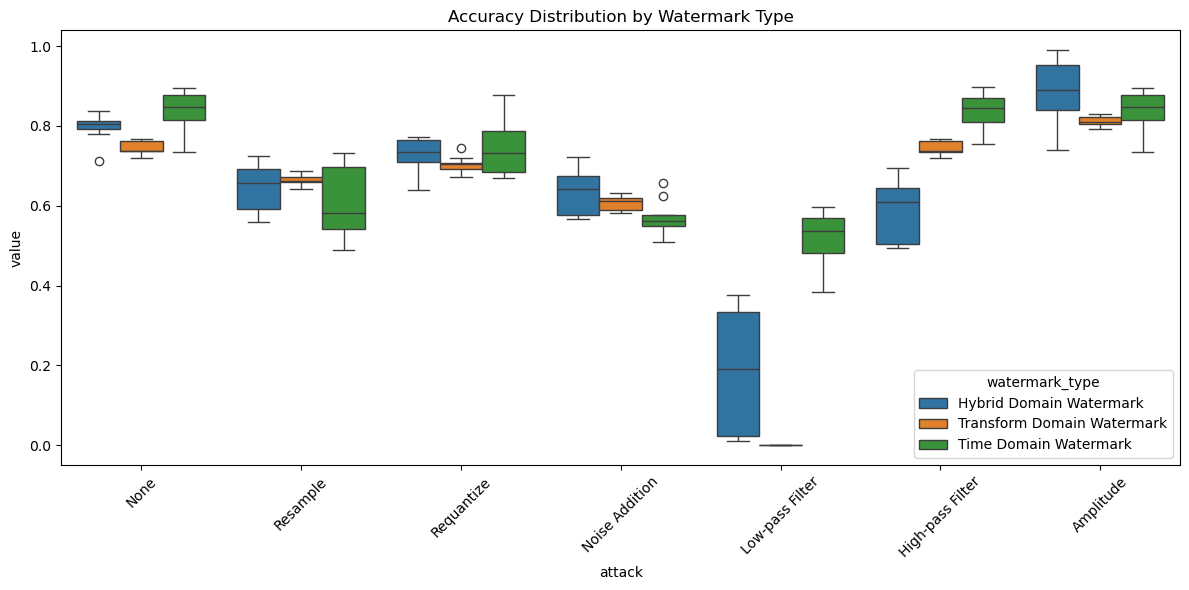

In [56]:
# Keep individual audio results to show variability
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['metric'] == metric_names_r[0]], 
            x='attack', y='value', hue='watermark_type')
plt.title('Accuracy Distribution by Watermark Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

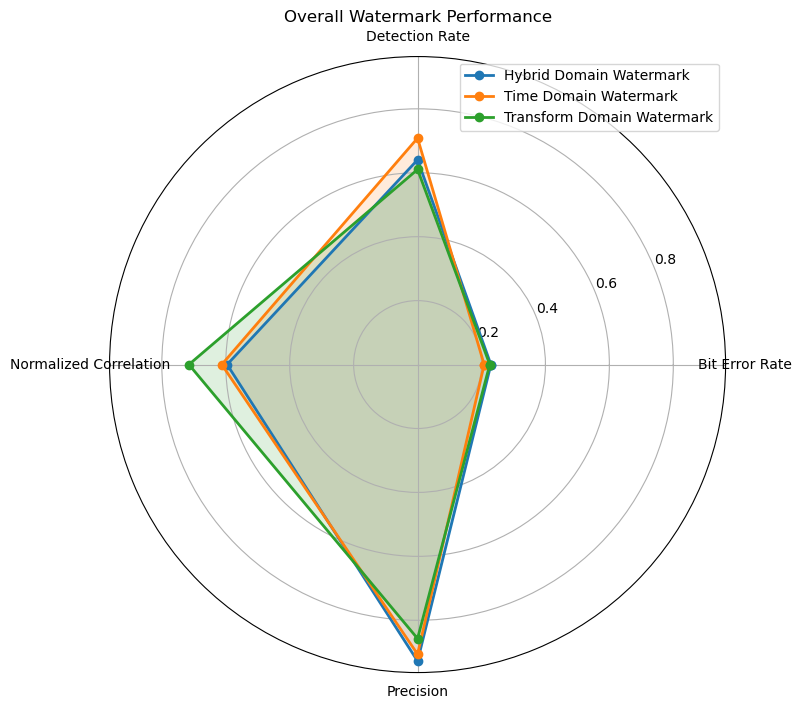

In [57]:
import numpy as np

# Average performance across all attacks for each watermark
summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

metrics = summary['metric'].unique()
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the plot

for watermark in summary['watermark_type'].unique():
    values = summary[summary['watermark_type'] == watermark]['value'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=watermark)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.legend(loc='upper right')
plt.title('Overall Watermark Performance')
plt.show()

In [14]:
df = df_perceptual

In [15]:
positive_values = df[(df['metric'] == 'Objective Difference Grade') & (df['value'] > 0)]
print(f"Number of positive values: {len(positive_values)}")
print(positive_values)

Number of positive values: 9
   audio_id         watermark_type                      metric     value
5       002  Time Domain Watermark  Objective Difference Grade  0.218578
11      003  Time Domain Watermark  Objective Difference Grade  0.218616
17      005  Time Domain Watermark  Objective Difference Grade  0.218510
23      010  Time Domain Watermark  Objective Difference Grade  0.218508
29      020  Time Domain Watermark  Objective Difference Grade  0.218230
35      026  Time Domain Watermark  Objective Difference Grade  0.218141
41      030  Time Domain Watermark  Objective Difference Grade  0.218428
47      046  Time Domain Watermark  Objective Difference Grade  0.218295
53      048  Time Domain Watermark  Objective Difference Grade  0.217706


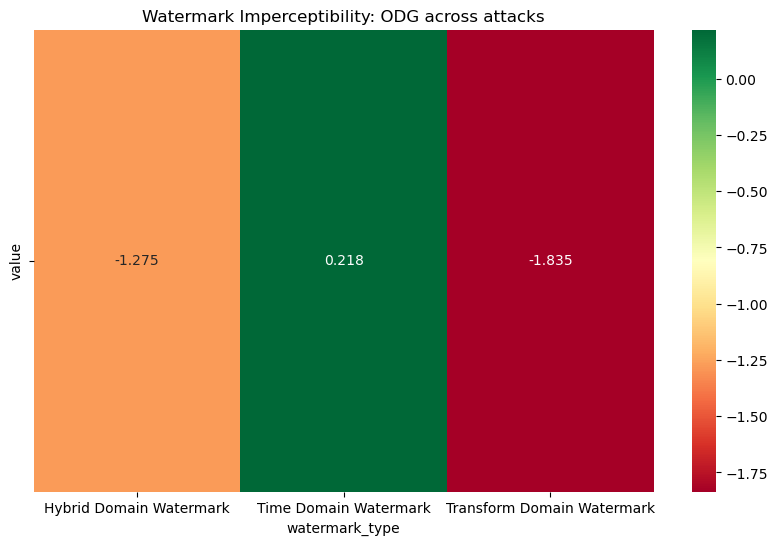

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt



heat_map(type=0, metric_number=0)

/tmp/ipykernel_2118207/3776286353.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Watermark')


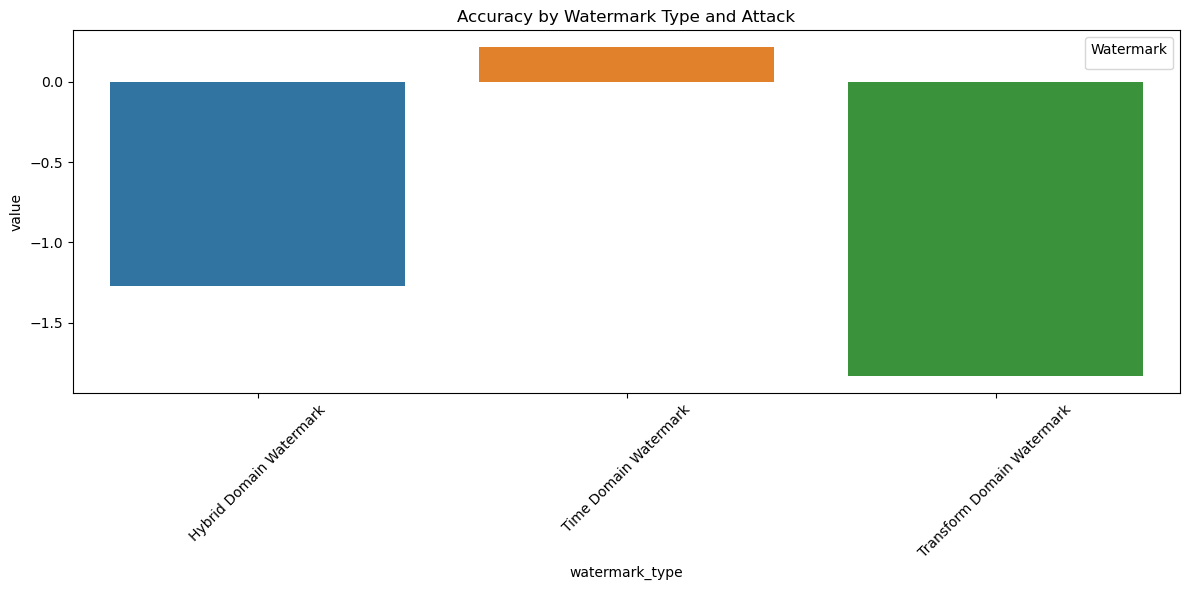

In [21]:
# Average across all audios
summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

# Plot one metric
metric_data = summary[summary['metric'] == metric_names_p[0]]

plt.figure(figsize=(12, 6))
sns.barplot(data=metric_data, x='watermark_type', y='value', hue='watermark_type')
plt.title('Accuracy by Watermark Type and Attack')
plt.xticks(rotation=45)
plt.legend(title='Watermark')
plt.tight_layout()
plt.show()

In [ ]:
summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

g = sns.FacetGrid(summary, col='metric', col_wrap=2, height=4, sharey=False)
g.map_dataframe(sns.barplot, x='attack', y='value', hue='watermark_type')
g.add_legend()
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Average performance across all attacks for each watermark
summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

metrics = summary['metric'].unique()
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the plot

for watermark in summary['watermark_type'].unique():
    values = summary[summary['watermark_type'] == watermark]['value'].tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=watermark)
    ax.fill(angles, values, alpha=0.15)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.legend(loc='upper right')
plt.title('Overall Watermark Performance')
plt.show()

### Plotting

In [ ]:
# todo fix labels

def heat_map(*, type: evaluation_type, metric_number: int):
    pivot_args = {
        'values': 'value',
        'columns': 'watermark_type',
        'aggfunc': 'mean'
    }
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
    else:
        metric_names = metric_names_r
        pivot_args['index'] = 'attack'
    # Pivot to show watermark performance across attacks for one metric
    pivot = df[df['metric'] == metric_names[metric_number]].pivot_table(**pivot_args)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn')
    plt.title('Watermark Imperceptibility: ODG across attacks')
    plt.show()

def bar_graph(*, type: evaluation_type, metric_number: int):
    groupby = ['watermark_type', 'metric']
    barplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        barplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        groupby.append('attack')
        barplot_args['x'] = 'attack'
        barplot_args['hue'] = 'watermark_type'
        
    # Average across all audios
    summary = df.groupby(groupby)['value'].mean().reset_index()

    # Plot one metric
    metric_data = summary[summary['metric'] == metric_names[metric_number]]

    plt.figure(figsize=(12, 6))
    sns.barplot(data=metric_data, y='value', **barplot_args)
    plt.title('Accuracy by Watermark Type and Attack')
    plt.xticks(rotation=45)
    plt.legend(title='Watermark')
    plt.tight_layout()
    plt.show()

def facet_bar_graph(*, type: evaluation_type, metric_number: int):
    groupby = ['watermark_type', 'metric']
    barplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        barplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        groupby.append('attack')
        barplot_args['x'] = 'attack'
        barplot_args['hue'] = 'watermark_type'
    summary = df.groupby(groupby)['value'].mean().reset_index()

    g = sns.FacetGrid(summary, col='metric', col_wrap=2, height=4, sharey=False)
    g.map_dataframe(sns.barplot, y='value', **barplot_args)
    g.add_legend()
    g.set_xticklabels(rotation=45)
    plt.tight_layout()
    plt.show()

def box_whisker(*, type: evaluation_type, metric_number: int):
    boxplot_args = {}
    if type == evaluation_type.PERCEPTUAL:
        metric_names = metric_names_p
        boxplot_args['x'] = 'watermark_type'
    else:
        metric_names = metric_names_r
        boxplot_args['x'] = 'attack'
        boxplot_args['hue'] = 'watermark_type'
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[df['metric'] == metric_names[metric_number]], y='value', **boxplot_args)
    plt.title('Accuracy Distribution by Watermark Type') 
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def spider_graph(*, type: evaluation_type, metric_number: int):
    # if type == evaluation_type.PERCEPTUAL:

    # else:

    # Average performance across all attacks for each watermark
    summary = df.groupby(['watermark_type', 'metric'])['value'].mean().reset_index()

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    metrics = summary['metric'].unique()
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the plot

    for watermark in summary['watermark_type'].unique():
        values = summary[summary['watermark_type'] == watermark]['value'].tolist()
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=watermark)
        ax.fill(angles, values, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.legend(loc='upper right')
    plt.title('Overall Watermark Performance')
    plt.show()

def all_graphs(*, type: evaluation_type, metric_number: int):
    box_whisker(type=type, metric_number=metric_number)
    facet_bar_graph(type=type, metric_number=metric_number)
    heat_map(type=type, metric_number=metric_number)
    spider_graph(type=type, metric_number=metric_number) # maybe not for perceptual

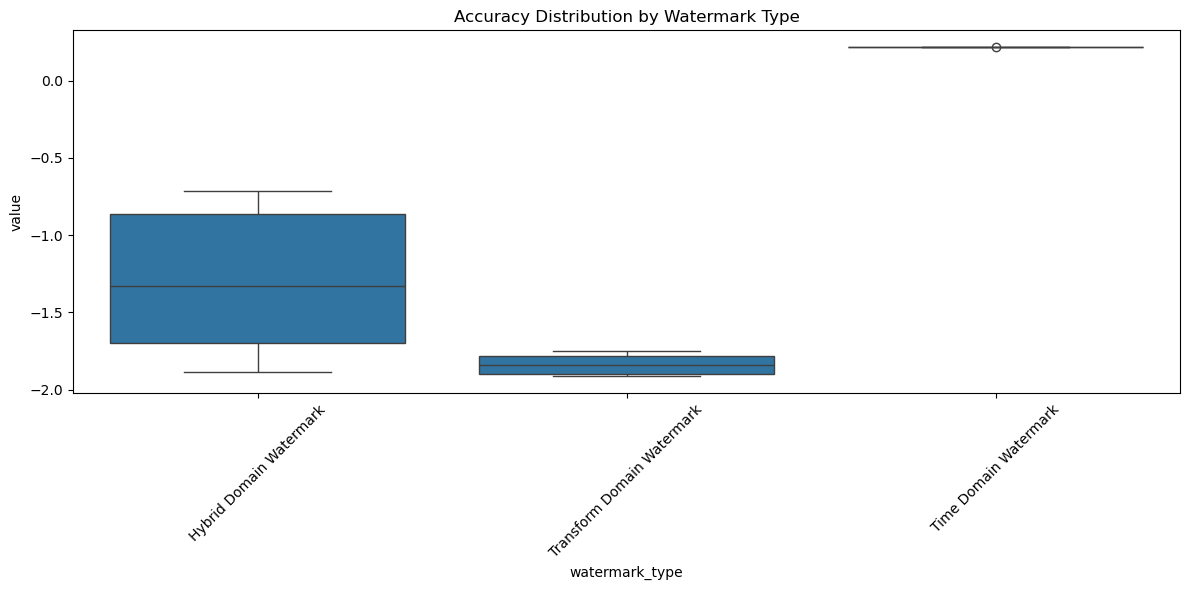

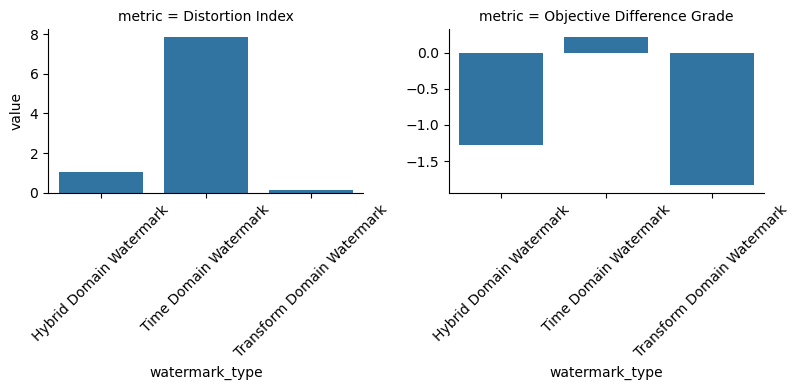

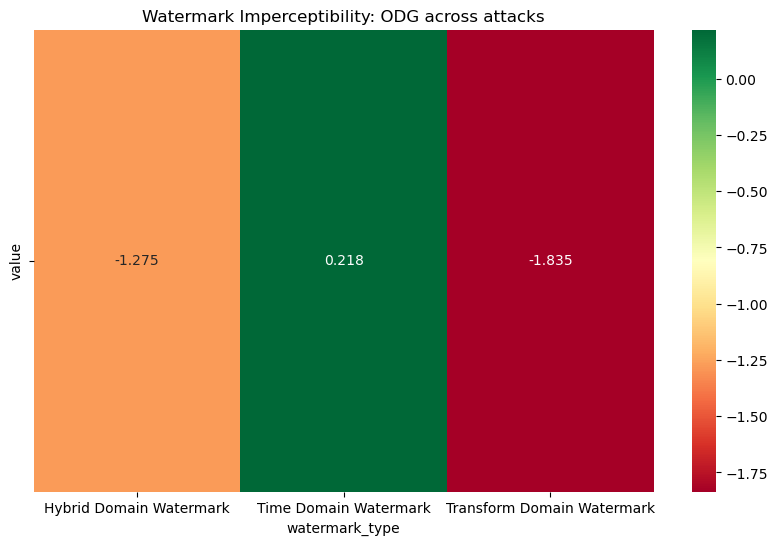

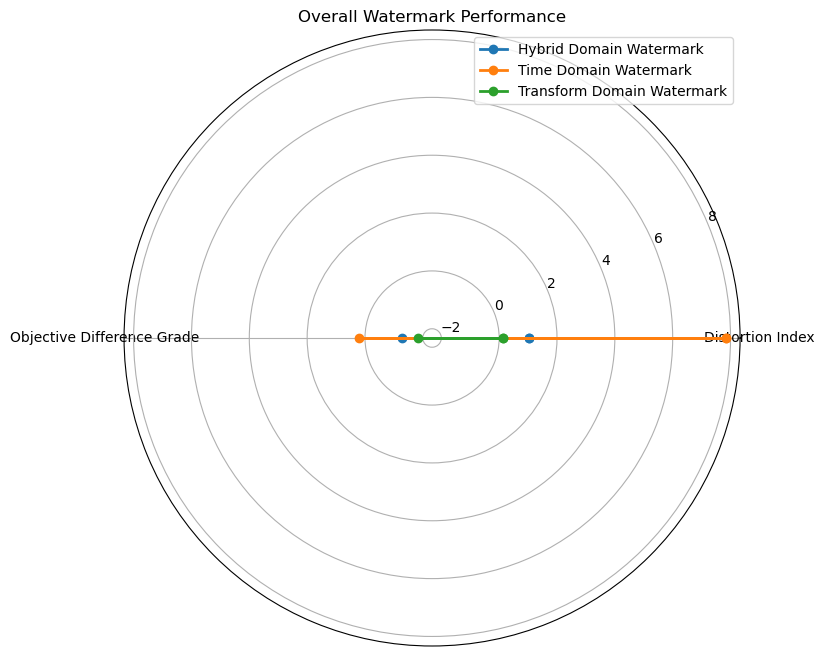

In [ ]:
all_graphs(type=evaluation_type.PERCEPTUAL, metric_number=0) # check it works for robustness